In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Logistic yerine AdaBoost ve DecisionTree ekledik
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.dummy import DummyClassifier
# Standart Pipeline kullanıyoruz (SMOTE olmadığı için imblearn pipeline'a gerek yok)
from sklearn.pipeline import Pipeline 

from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, 
                             f1_score, make_scorer, roc_auc_score, roc_curve, auc,
                             precision_recall_curve, average_precision_score, precision_score, recall_score)

warnings.filterwarnings('ignore')

In [17]:
# ======================================================================================
# --- BÖLÜM 0 ve 1: VERİ YÜKLEME VE DENGELİ ÖRNEKLEME ---
# ======================================================================================
print("############################################################")
print("### ADIM 1: VERİ YÜKLEME VE HAZIRLIK ###")
print("############################################################\n")

# Dosya yolunun doğru olduğundan emin ol
df = pd.read_csv('US_Accidents_March23.csv') 
print(f"Veri Seti Boyutu: {df.shape}")

print("\n--- Stratified Dengeli Örnekleme Uygulanıyor ---")
sample_sizes = {
    1: 9999999,
    2: 1600000,
    3: 9999999,
    4: 9999999  # Mevcut tüm veriler
}

dfs = []
for severity, size in sample_sizes.items():
    df_class = df[df['Severity'] == severity]
    if len(df_class) < size:
        dfs.append(df_class)
    else:
        dfs.append(df_class.sample(n=size, random_state=42))

df_sample = pd.concat(dfs, ignore_index=True)
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)
del df # Bellek temizliği

print(f"\n--- Dengeli Örneklem Sonrası Toplam: {len(df_sample)} ---")
print(df_sample['Severity'].value_counts())

print("\n--- Veri, Eğitim ve Test Setlerine Bölünüyor ---")
X = df_sample.drop('Severity', axis=1)
y = df_sample['Severity']

# Stratify parametresini y olarak veriyoruz ki dağılım korunsun
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim seti: {X_train.shape}")
print(f"Test seti: {X_test.shape}")

############################################################
### ADIM 1: VERİ YÜKLEME VE HAZIRLIK ###
############################################################

Veri Seti Boyutu: (7728394, 46)

--- Stratified Dengeli Örnekleme Uygulanıyor ---

--- Dengeli Örneklem Sonrası Toplam: 3171413 ---
Severity
2    1600000
3    1299337
4     204710
1      67366
Name: count, dtype: int64

--- Veri, Eğitim ve Test Setlerine Bölünüyor ---
Eğitim seti: (2537130, 45)
Test seti: (634283, 45)


In [18]:
# ======================================================================================
# --- BÖLÜM 2: ÖZELLİK YARATMA FONKSİYONU ---
# ======================================================================================
def feature_creation_pipeline(df_input):
    df = df_input.copy()
    
    # Zamansal özellikler
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
    df['Hour'] = df['Start_Time'].dt.hour
    df['Month'] = df['Start_Time'].dt.month
    df['DayOfWeek'] = df['Start_Time'].dt.dayofweek
    df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(int)
    df['Is_Rush_Hour'] = ((df['Is_Weekend'] == 0) & (df['Hour'].isin([7, 8, 9, 15, 16, 17, 18]))).astype(int)
    df['Duration(min)'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
    df.loc[df['Duration(min)'] < 0, 'Duration(min)'] = 0

    # Yol (Street) özellikleri
    if 'Street' in df.columns:
        df['Street'].fillna('Unknown', inplace=True)
        highway_keywords = ['Hwy', 'Fwy', 'Pkwy', 'Expy', 'Blvd', 'Highway', 'Freeway', 'I-', 'US-']
        df['Is_Highway'] = df['Street'].apply(lambda x: 1 if any(kw in str(x) for kw in highway_keywords) else 0)
        low_speed_keywords = ['St', 'Dr', 'Ave', 'Rd', 'Ln', 'Ct', 'Pl']
        pattern = r'\b(' + '|'.join(low_speed_keywords) + r')\b'
        df['Is_Low_Speed_Zone'] = df['Street'].str.contains(pattern, case=False, na=False).astype(int)

    # Metin (Description) özellikleri
    if 'Description' in df.columns:
        desc_lower = df['Description'].str.lower().fillna('')
        df['FEAT_Is_Road_Closed'] = desc_lower.str.contains('closed|closure', na=False).astype(int)
        df['FEAT_Is_Lane_Blocked'] = desc_lower.str.contains('blocked|lane', na=False).astype(int)
        df['FEAT_Is_Slowdown'] = desc_lower.str.contains('traffic|slow|caution', na=False).astype(int)
        df['FEAT_Is_Crash'] = desc_lower.str.contains('crash', na=False).astype(int)
        
    return df

print("Özellikler türetiliyor...")
X_train_created = feature_creation_pipeline(X_train)
X_test_created = feature_creation_pipeline(X_test)
print("Tamamlandı.")

Özellikler türetiliyor...
Tamamlandı.


In [19]:
# ======================================================================================
# --- BÖLÜM 3-5: TEMİZLEME VE SAYISALLAŞTIRMA ---
# ======================================================================================
print("Veri temizleme ve ön işleme başlıyor...")

cols_to_drop = [
    'ID', 'Source', 'End_Lat', 'End_Lng', 'County', 'Zipcode', 'Country', 
    'Start_Time', 'End_Time', 'Timezone', 'Airport_Code', 
    'Street', 'Description',
    'Weather_Timestamp', 'Wind_Chill(F)', 'Precipitation(in)', 'Weather_Condition'
]
X_train_selected = X_train_created.drop(columns=cols_to_drop, errors='ignore')
X_test_selected = X_test_created.drop(columns=cols_to_drop, errors='ignore')

# Şehir bazlı sıcaklık doldurma
city_median_temps_map = X_train_selected.groupby('City')['Temperature(F)'].median()
X_train_imputed = X_train_selected.copy()
X_test_imputed = X_test_selected.copy()
X_train_imputed['Temperature(F)'].fillna(X_train_imputed['City'].map(city_median_temps_map), inplace=True)
X_test_imputed['Temperature(F)'].fillna(X_test_imputed['City'].map(city_median_temps_map), inplace=True)
X_train_imputed.drop(columns=['City'], inplace=True)
X_test_imputed.drop(columns=['City'], inplace=True)

# Aykırı değerleri (Outlier) baskılama
cols_to_clip = ['Temperature(F)', 'Wind_Speed(mph)', 'Distance(mi)', 'Duration(min)', 'Pressure(in)', 'Humidity(%)', 'Visibility(mi)']
for col in cols_to_clip:
    if col in X_train_imputed.columns:
        lower, upper = X_train_imputed[col].quantile(0.01), X_train_imputed[col].quantile(0.99)
        X_train_imputed[col] = X_train_imputed[col].clip(lower=lower, upper=upper)
        X_test_imputed[col] = X_test_imputed[col].clip(lower=lower, upper=upper)

# Kalan eksik verileri doldurma
fill_values = {col: (X_train_imputed[col].median() if pd.api.types.is_numeric_dtype(X_train_imputed[col]) else X_train_imputed[col].mode()[0]) for col in X_train_imputed.columns if X_train_imputed[col].isnull().sum() > 0}
X_train_imputed.fillna(value=fill_values, inplace=True)
X_test_imputed.fillna(value=fill_values, inplace=True)

# Boolean -> Integer
bool_cols = X_train_imputed.select_dtypes(include='bool').columns
X_train_imputed[bool_cols] = X_train_imputed[bool_cols].astype(int)
X_test_imputed[bool_cols] = X_test_imputed[bool_cols].astype(int)

# One-Hot Encoding
categorical_cols = X_train_imputed.select_dtypes(include='object').columns.tolist()
if len(categorical_cols) > 0:
    X_train_final = pd.get_dummies(X_train_imputed, columns=categorical_cols, drop_first=True)
    X_test_final = pd.get_dummies(X_test_imputed, columns=categorical_cols, drop_first=True)
    # Test setinde eksik sütunları 0 ile doldur
    missing_in_test = set(X_train_final.columns) - set(X_test_final.columns)
    for c in missing_in_test: 
        X_test_final[c] = 0
    X_test_final = X_test_final[X_train_final.columns]
else:
    X_train_final = X_train_imputed.copy()
    X_test_final = X_test_imputed.copy()

# Hedef değişkeni 0-3 arasına çekme (Label Adjustment)
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

print(f"Final Eğitim Verisi Boyutu: {X_train_final.shape}")

Veri temizleme ve ön işleme başlıyor...
Final Eğitim Verisi Boyutu: (2537130, 108)


In [20]:
# ======================================================================================
# --- BÖLÜM 7: BASELINE MODEL (DUMMY) ---
# ======================================================================================
print("Baseline Model (Majority Class) Eğitiliyor...")

dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_model.fit(X_train_final, y_train_adjusted)
y_pred_baseline = dummy_model.predict(X_test_final)

baseline_f1_macro = f1_score(y_test_adjusted, y_pred_baseline, average='macro')
print(f"Baseline F1-Macro Score: {baseline_f1_macro:.4f}")

Baseline Model (Majority Class) Eğitiliyor...
Baseline F1-Macro Score: 0.1677


In [21]:
# ======================================================================================
# --- BÖLÜM 8: ADABOOST - TURBO MOD (PCA YOK, AZ AĞAÇ) ---
# ======================================================================================
print("############################################################")
print("### ADIM 8: ADABOOST MODEL EĞİTİMİ (TURBO MOD) ###")
print("############################################################\n")

# Pipeline sadeleşti: Scaler YOK, PCA YOK. Direkt model.
# Bu sayede çok daha hızlı çalışacak.
pipeline = Pipeline([
    ('clf', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2), # Derinlik 1 (Stump) en hızlısıdır
        n_estimators=50,  # Sayıyı 20'ye çektim, hemen bitsin diye. Sonra artırırsın.
        learning_rate=1.0,
        random_state=42
    ))
])

print("Model eğitimi başlıyor (PCA yok, 20 Ağaç, Tek sefer)...")
start_time = time.time()

# Direkt fit ediyoruz
pipeline.fit(X_train_final, y_train_adjusted)

end_time = time.time()
print(f"\nEğitim bitti! Süre: {end_time - start_time:.2f} saniye")

# --- SONRAKİ HÜCRELER İÇİN MOCK OBJE ---
class MockGridSearch:
    def __init__(self, model):
        self.best_estimator_ = model
        self.best_params_ = {
            'pca__n_components': "None", 
            'clf__n_estimators': 20, 
            'clf__learning_rate': 1.0
        }
        self.best_score_ = "N/A (CV yapılmadı)"

grid_search = MockGridSearch(pipeline)
print("Model hazır, değerlendirme hücresine geçebilirsin.")

############################################################
### ADIM 8: ADABOOST MODEL EĞİTİMİ (TURBO MOD) ###
############################################################

Model eğitimi başlıyor (PCA yok, 20 Ağaç, Tek sefer)...

Eğitim bitti! Süre: 462.14 saniye
Model hazır, değerlendirme hücresine geçebilirsin.


############################################################
### MODEL DEĞERLENDİRMESİ VE GÖRSELLEŞTİRME ###
############################################################

✅ Test F1-Macro Score (AdaBoost): 0.7420

📋 Classification Report:
              precision    recall  f1-score   support

  Severity 1       0.73      0.65      0.69     13473
  Severity 2       0.81      0.80      0.81    320000
  Severity 3       0.79      0.77      0.78    259868
  Severity 4       0.61      0.79      0.69     40942

    accuracy                           0.79    634283
   macro avg       0.74      0.76      0.74    634283
weighted avg       0.79      0.79      0.79    634283



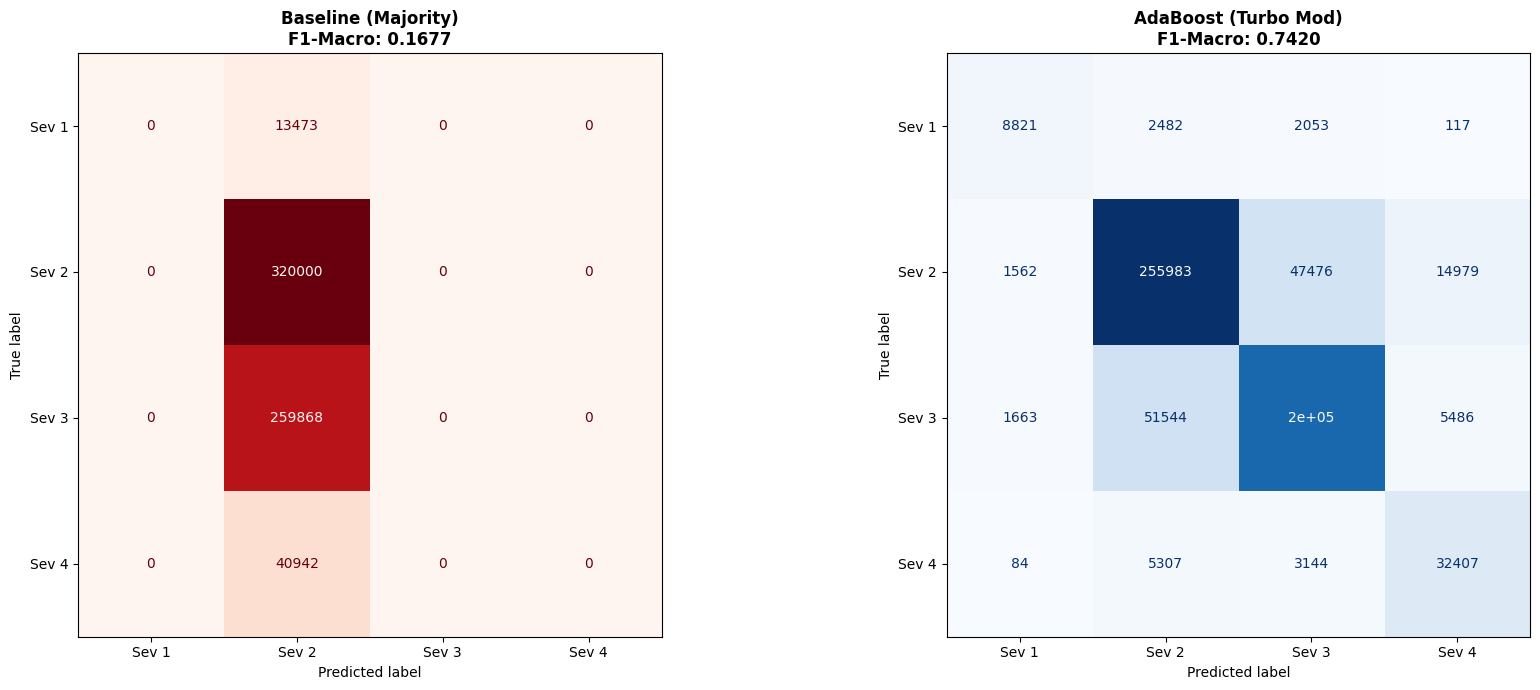

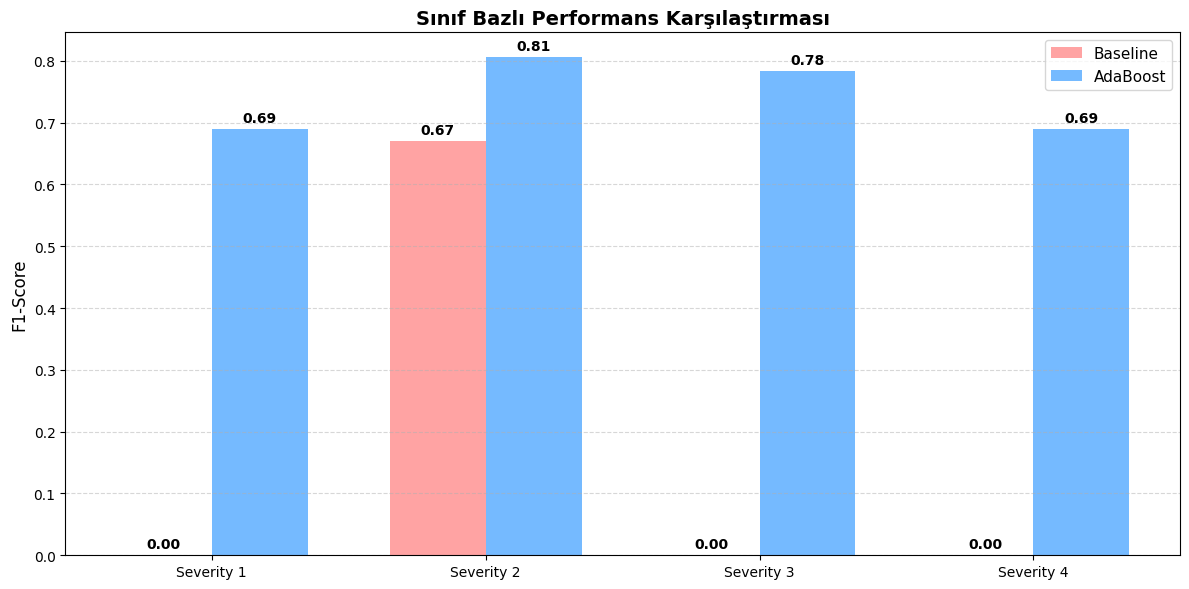

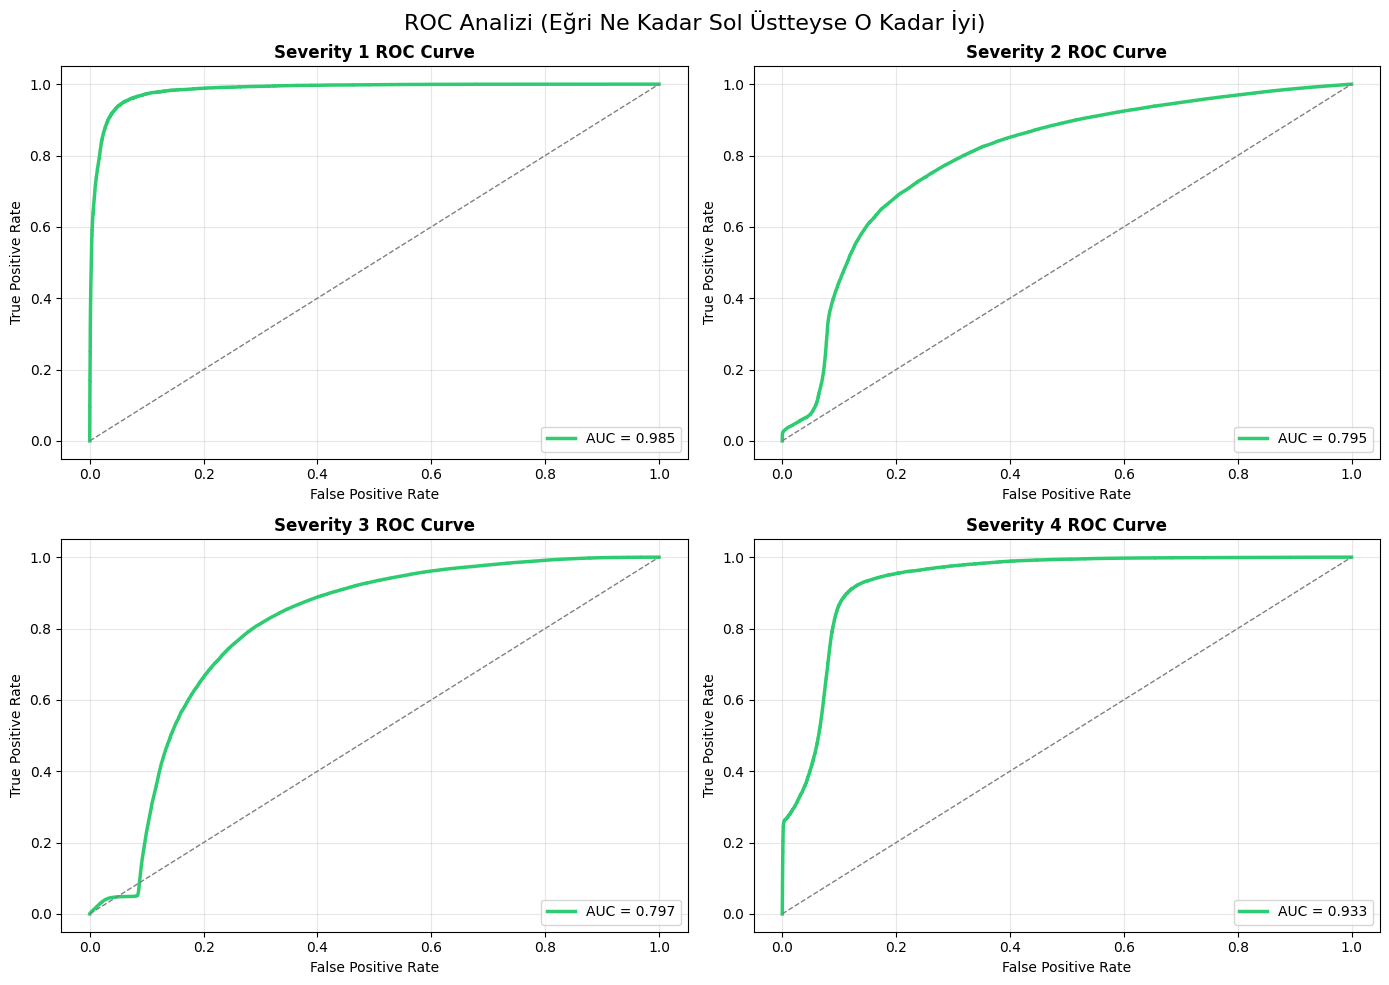

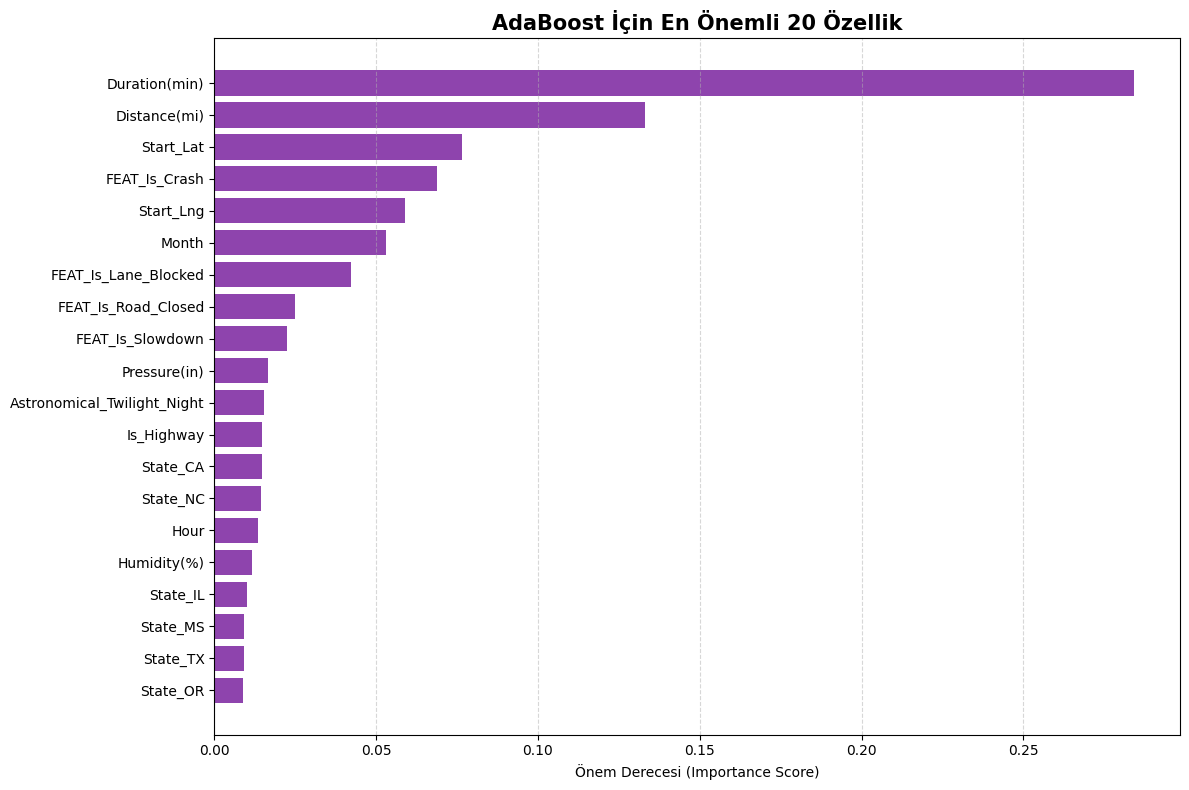


### TÜM İŞLEMLER TAMAMLANDI 🎉 ###


In [22]:
# ======================================================================================
# --- BÖLÜM 9-13: DEĞERLENDİRME VE DETAYLI GÖRSELLEŞTİRME (PCA YOK) ---
# ======================================================================================
print("############################################################")
print("### MODEL DEĞERLENDİRMESİ VE GÖRSELLEŞTİRME ###")
print("############################################################\n")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)
severity_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']

# --- SKORLAR ---
test_f1_macro = f1_score(y_test_adjusted, y_pred, average='macro')
test_f1_per_class = f1_score(y_test_adjusted, y_pred, average=None)
baseline_f1_per_class = f1_score(y_test_adjusted, y_pred_baseline, average=None)

print(f"✅ Test F1-Macro Score (AdaBoost): {test_f1_macro:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test_adjusted, y_pred, target_names=severity_names))

# --- GRAFİKLER ---

# 1. Confusion Matrix Karşılaştırması (Baseline vs AdaBoost)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Baseline CM
cm_baseline = confusion_matrix(y_test_adjusted, y_pred_baseline)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
disp1.plot(cmap=plt.cm.Reds, ax=axes[0], colorbar=False)
axes[0].set_title(f'Baseline (Majority)\nF1-Macro: {baseline_f1_macro:.4f}', fontsize=12, fontweight='bold')

# AdaBoost CM
cm = confusion_matrix(y_test_adjusted, y_pred)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
disp2.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=False)
axes[1].set_title(f'AdaBoost (Turbo Mod)\nF1-Macro: {test_f1_macro:.4f}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Sınıf Bazlı F1-Score Karşılaştırması (Bar Chart)
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(severity_names))
width = 0.35

rects1 = ax.bar(x - width/2, baseline_f1_per_class, width, label='Baseline', color='#ff9999', alpha=0.9)
rects2 = ax.bar(x + width/2, test_f1_per_class, width, label='AdaBoost', color='#66b3ff', alpha=0.9)

ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Sınıf Bazlı Performans Karşılaştırması', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(severity_names)
ax.legend(fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Barların üzerine değer yazma
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()

# 3. ROC Eğrileri (One-vs-Rest)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, name in enumerate(severity_names):
    y_test_binary = (y_test_adjusted == i).astype(int)
    y_score = y_pred_proba[:, i]
    
    fpr, tpr, _ = roc_curve(y_test_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    axes[i].plot(fpr, tpr, color='#2ecc71', lw=2.5, label=f'AUC = {roc_auc:.3f}')
    axes[i].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'{name} ROC Curve', fontweight='bold')
    axes[i].legend(loc="lower right")
    axes[i].grid(True, alpha=0.3)

plt.suptitle("ROC Analizi (Eğri Ne Kadar Sol Üstteyse O Kadar İyi)", fontsize=16)
plt.tight_layout()
plt.show()

# 4. Feature Importance (Özellik Önem Düzeyi) - PCA yerine bu geldi
# Modelin hangi özelliklere bakarak karar verdiğini gösterir
if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
    importances = best_model.named_steps['clf'].feature_importances_
    indices = np.argsort(importances)[::-1]
    top_n = 20 # En önemli 20 özellik
    
    plt.figure(figsize=(12, 8))
    plt.title(f"AdaBoost İçin En Önemli {top_n} Özellik", fontsize=15, fontweight='bold')
    plt.barh(range(top_n), importances[indices[:top_n]], align="center", color='#8e44ad')
    plt.yticks(range(top_n), [X_train_final.columns[i] for i in indices[:top_n]], fontsize=10)
    plt.xlabel("Önem Derecesi (Importance Score)")
    plt.gca().invert_yaxis() # En önemlisi en üstte olsun
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Kullanılan base estimator feature importance desteklemiyor.")

print("\n### TÜM İŞLEMLER TAMAMLANDI 🎉 ###")

In [24]:
# ======================================================================================
# --- BÖLÜM 14: CATBOOST MODEL EĞİTİMİ ---
# ======================================================================================
print("############################################################")
print("### YENİ MODEL: CATBOOST CLASSIFIER ###")
print("############################################################\n")

# CatBoost kütüphanesini yüklüyoruz
#!pip install catboost -q

from catboost import CatBoostClassifier
import time

print("CatBoost modeli hazırlanıyor...")

# CatBoost Parametreleri
# task_type="CPU" (GPU varsa "GPU" yapabilirsin, çok hızlanır)
cb_model = CatBoostClassifier(
    iterations=500,          # Maksimum ağaç sayısı
    learning_rate=0.1,       # Öğrenme hızı
    depth=8,                 # Ağaç derinliği (6-10 arası iyidir)
    loss_function='MultiClass',
    eval_metric='TotalF1',   # Takip edilecek metrik
    early_stopping_rounds=30,# 20 tur boyunca iyileşme olmazsa dur
    verbose=50,              # Her 50 adımda bir bilgi yaz
    random_state=42
)

print("Eğitim Başlıyor (İlerlemeyi aşağıda göreceksin)...")
start_time = time.time()

# Modeli Eğit
# Not: CatBoost, One-Hot Encode edilmiş veriyi de sayısal gibi işler, sorun yok.
cb_model.fit(
    X_train_final, y_train_adjusted,
    eval_set=(X_test_final, y_test_adjusted), # Test setini doğrulama için kullanıyoruz
    use_best_model=True
)

end_time = time.time()
print(f"\n✅ Eğitim Tamamlandı! Süre: {end_time - start_time:.2f} saniye")

############################################################
### YENİ MODEL: CATBOOST CLASSIFIER ###
############################################################

CatBoost modeli hazırlanıyor...
Eğitim Başlıyor (İlerlemeyi aşağıda göreceksin)...
0:	learn: 0.7888131	test: 0.7880829	best: 0.7880829 (0)	total: 1.29s	remaining: 10m 41s
50:	learn: 0.8224182	test: 0.8217738	best: 0.8217738 (50)	total: 53.9s	remaining: 7m 54s
100:	learn: 0.8354892	test: 0.8349324	best: 0.8349324 (100)	total: 1m 45s	remaining: 6m 56s
150:	learn: 0.8429661	test: 0.8421025	best: 0.8421025 (150)	total: 2m 36s	remaining: 6m
200:	learn: 0.8477002	test: 0.8467533	best: 0.8467533 (200)	total: 3m 27s	remaining: 5m 8s
250:	learn: 0.8512555	test: 0.8501118	best: 0.8501118 (250)	total: 4m 17s	remaining: 4m 15s
300:	learn: 0.8543923	test: 0.8532373	best: 0.8532373 (300)	total: 5m 9s	remaining: 3m 24s
350:	learn: 0.8569653	test: 0.8554847	best: 0.8554847 (350)	total: 5m 59s	remaining: 2m 32s
400:	learn: 0.8589548	test: 0.8

############################################################
### CATBOOST MODEL DEĞERLENDİRMESİ ###
############################################################

🚀 CatBoost F1-Macro Score: 0.8344

📋 Classification Report:
              precision    recall  f1-score   support

  Severity 1       0.84      0.76      0.80     13473
  Severity 2       0.89      0.85      0.87    320000
  Severity 3       0.83      0.89      0.86    259868
  Severity 4       0.80      0.82      0.81     40942

    accuracy                           0.86    634283
   macro avg       0.84      0.83      0.83    634283
weighted avg       0.86      0.86      0.86    634283



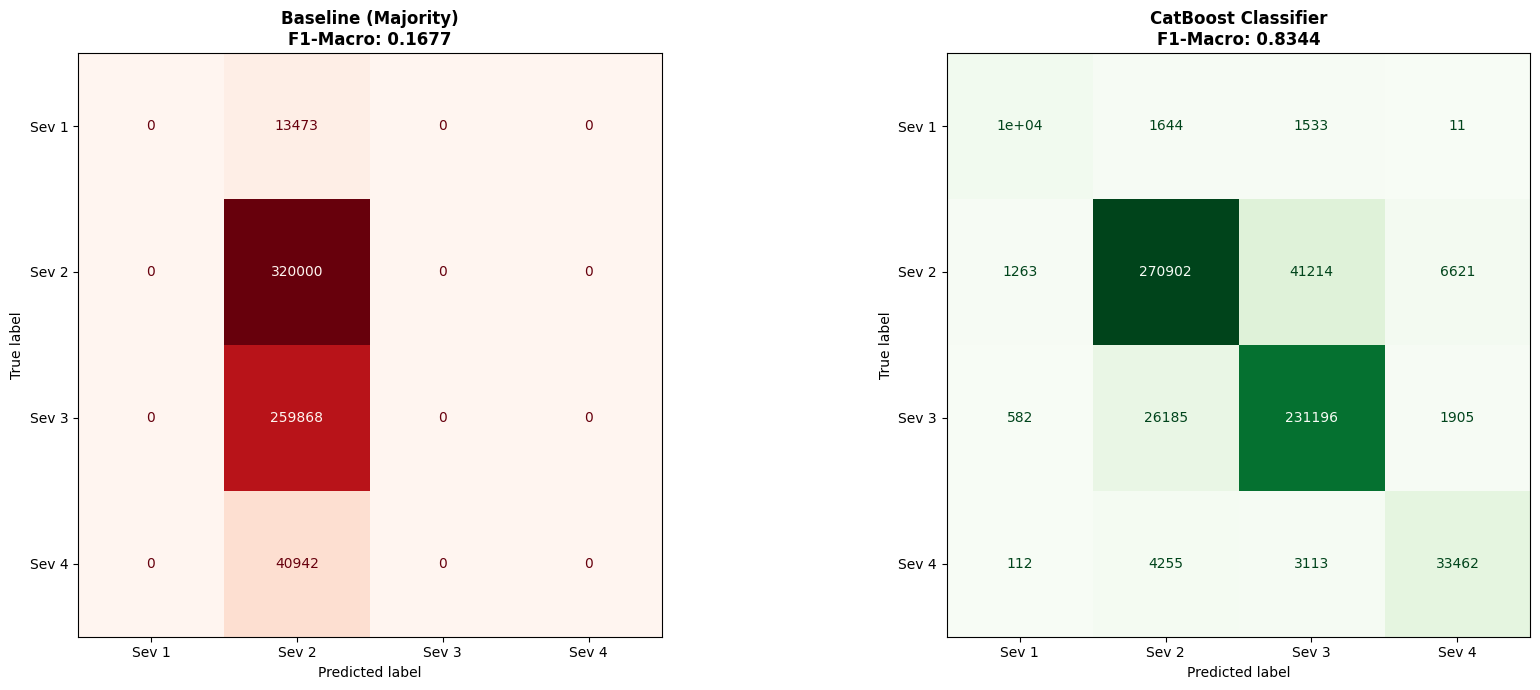

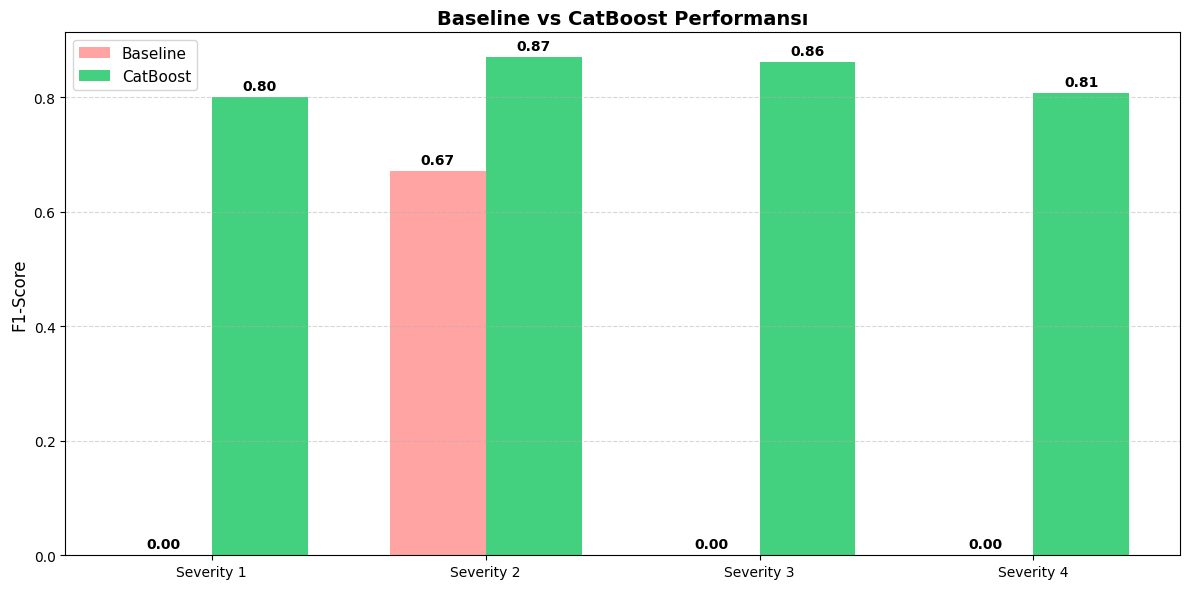

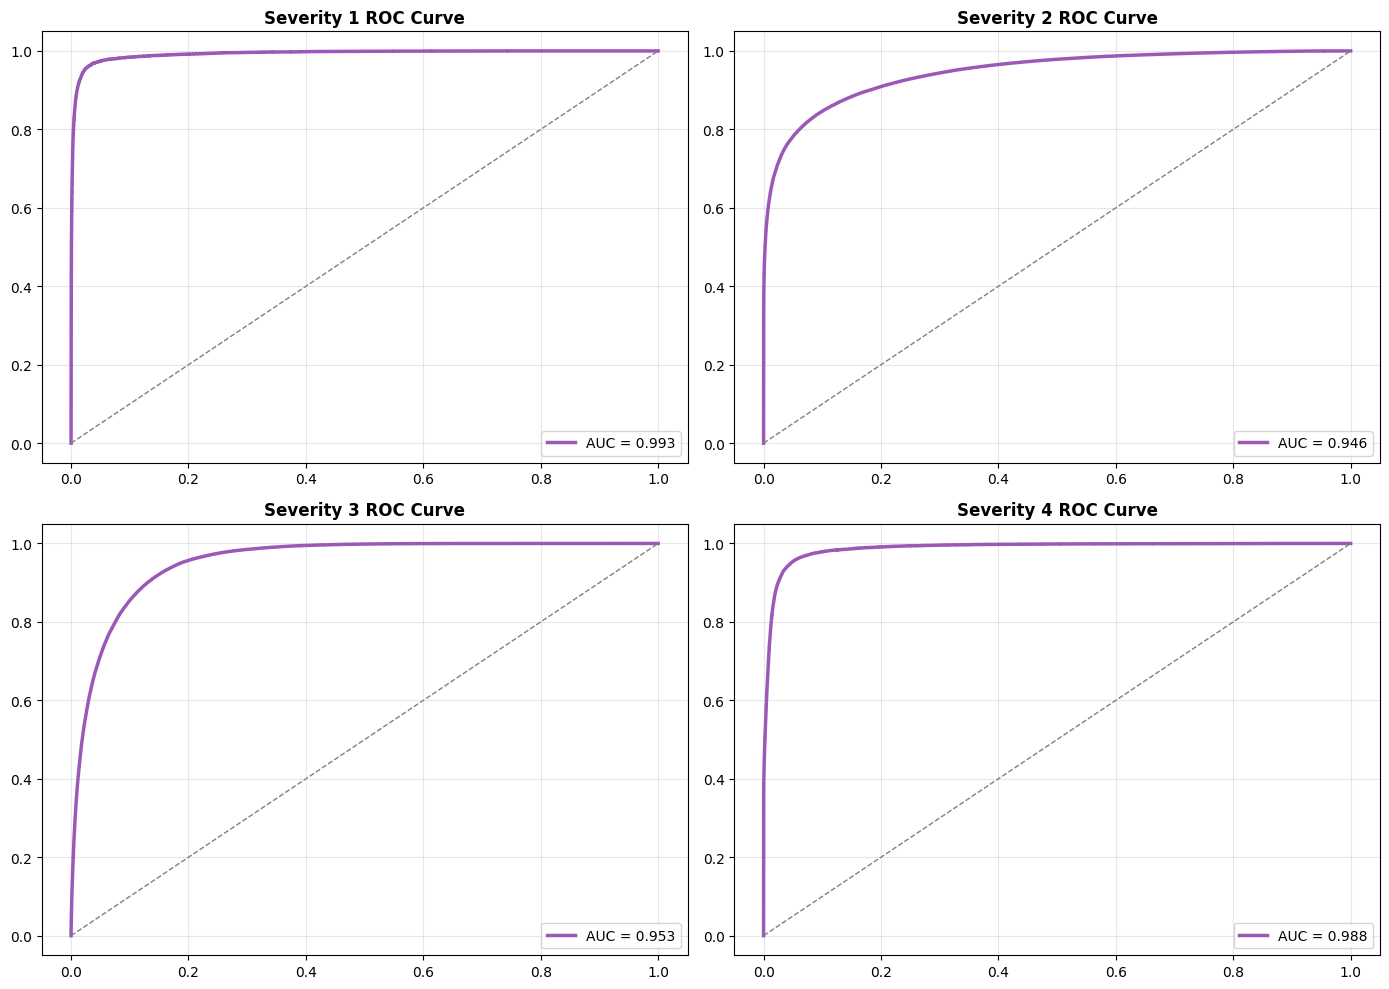

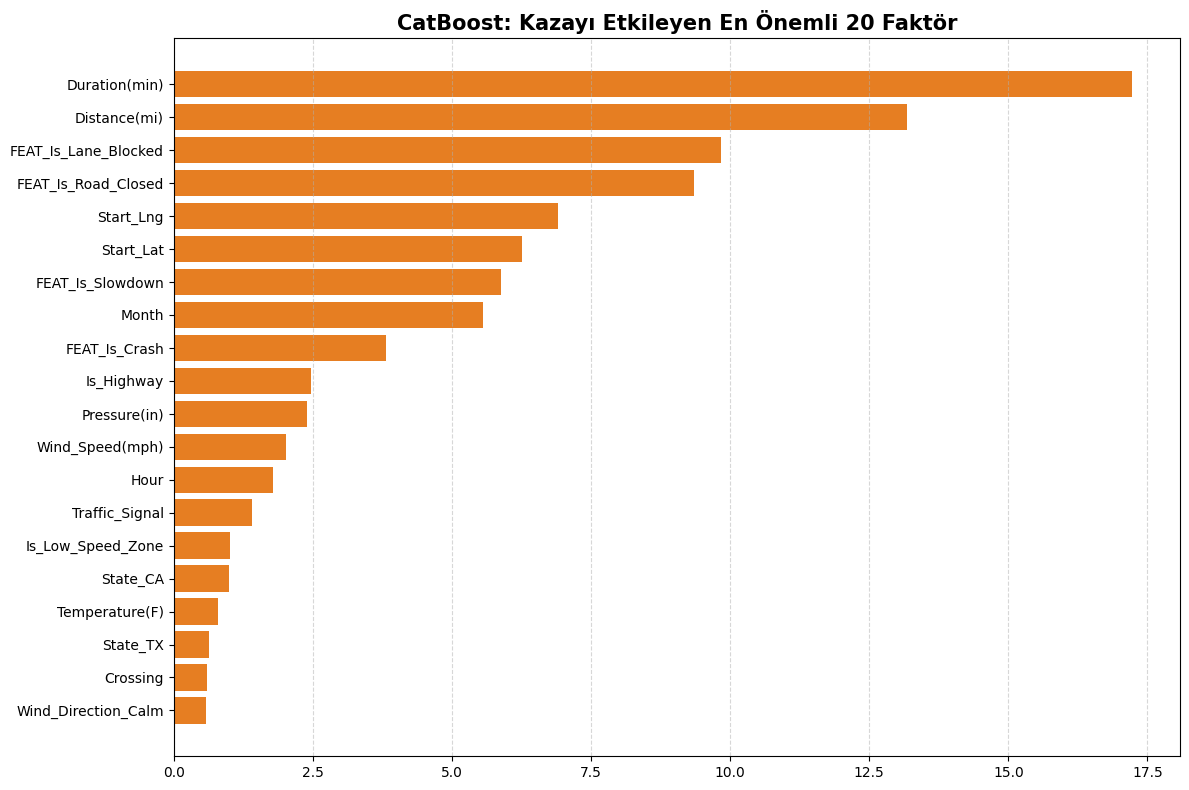


### CATBOOST ANALİZİ TAMAMLANDI ###


In [25]:
# ======================================================================================
# --- BÖLÜM 15: CATBOOST SONUÇLARI VE GÖRSELLEŞTİRME ---
# ======================================================================================
print("############################################################")
print("### CATBOOST MODEL DEĞERLENDİRMESİ ###")
print("############################################################\n")

# Tahminler
y_pred_cb = cb_model.predict(X_test_final).flatten() # Boyut düzeltme
y_pred_proba_cb = cb_model.predict_proba(X_test_final)

severity_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']

# Skorlar
cb_f1_macro = f1_score(y_test_adjusted, y_pred_cb, average='macro')
cb_f1_per_class = f1_score(y_test_adjusted, y_pred_cb, average=None)

print(f"🚀 CatBoost F1-Macro Score: {cb_f1_macro:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test_adjusted, y_pred_cb, target_names=severity_names))

# --- GRAFİKLER ---

# 1. Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Baseline (Önceki referans)
cm_baseline = confusion_matrix(y_test_adjusted, y_pred_baseline)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
disp1.plot(cmap=plt.cm.Reds, ax=axes[0], colorbar=False)
axes[0].set_title(f'Baseline (Majority)\nF1-Macro: {baseline_f1_macro:.4f}', fontsize=12, fontweight='bold')

# CatBoost
cm_cb = confusion_matrix(y_test_adjusted, y_pred_cb)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_cb, display_labels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
disp2.plot(cmap=plt.cm.Greens, ax=axes[1], colorbar=False)
axes[1].set_title(f'CatBoost Classifier\nF1-Macro: {cb_f1_macro:.4f}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Sınıf Bazlı F1-Score (Baseline vs CatBoost)
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(severity_names))
width = 0.35

rects1 = ax.bar(x - width/2, baseline_f1_per_class, width, label='Baseline', color='#ff9999', alpha=0.9)
rects2 = ax.bar(x + width/2, cb_f1_per_class, width, label='CatBoost', color='#2ecc71', alpha=0.9)

ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Baseline vs CatBoost Performansı', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(severity_names)
ax.legend(fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.5)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()

# 3. ROC Eğrileri
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, name in enumerate(severity_names):
    y_test_binary = (y_test_adjusted == i).astype(int)
    y_score = y_pred_proba_cb[:, i]
    fpr, tpr, _ = roc_curve(y_test_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    axes[i].plot(fpr, tpr, color='#9b59b6', lw=2.5, label=f'AUC = {roc_auc:.3f}')
    axes[i].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    axes[i].set_title(f'{name} ROC Curve', fontweight='bold')
    axes[i].legend(loc="lower right")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Feature Importance (CatBoost Yerleşik Özellik)
feature_importance = cb_model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)[::-1]
top_n = 20

plt.figure(figsize=(12, 8))
plt.title(f"CatBoost: Kazayı Etkileyen En Önemli {top_n} Faktör", fontsize=15, fontweight='bold')
plt.barh(range(top_n), feature_importance[sorted_idx[:top_n]], align='center', color='#e67e22')
plt.yticks(range(top_n), np.array(X_train_final.columns)[sorted_idx[:top_n]], fontsize=10)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\n### CATBOOST ANALİZİ TAMAMLANDI ###")